# Laboratorium 3

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
import random
import math
import functools
import time
import heapq 

In [2]:
def gen_lines(num):
    xMax = 1000
    yMax = 1000
    for _ in range(num):
        new_added_lines.append( Line(Point(random.uniform(0, xMax), random.uniform(0, yMax))
                                  , Point(random.uniform(0, xMax), random.uniform(0, yMax))))
def get_all_lines():
    return LinesCollection([ line.as_list() for line in new_added_lines])

EPS = 10**(-13)

def orient(a, b, c):
    arr = np.array([ [a[0] - c[0], a[1] - c[1]], [b[0]-c[0], b[1]-c[1]] ])
    det = np.linalg.det(arr)
    #print("det", det)
    if det-EPS > 0: return 1
    elif det+EPS < 0: return -1
    else: return 0
    
def intersect(a1, a2, b1, b2) :
    o1 = orient( a1 , a2 , b1 )
    o2 = orient( a1 , a2 , b2 )
    o3 = orient( b1 , b2 , a1 )
    o4 = orient( b1 , b2 , a2 )
    if ( o1 != o2 ) and ( o3 != o4 ) :
        return True
    else:
        return False
    
"""
http://www.izdebski.edu.pl/kategorie/Informatyka/Cwiczenie_02.pdf
x_p = a1.x + t * dX_a1_a2
y_p = a1.y + t * dY_a1_a2

    dX_a1_b1 * dY_b1_b2 - dY_a1_b1 * dX_b1_b2
t = -----------------------------------------
    dX_a1_a2 * dY_b1_b2 - dY_a1_a2 * dX_b1_b2
    
"""
def dX(a, b): return b[0] - a[0]
def dY(a, b): return b[1] - a[1]
def intersect_point(a1, a2, b1, b2):
    dX_a1_a2 = dX(a1, a2)
    dY_a1_a2 = dY(a1, a2)
    
    dX_a1_b1 = dX(a1, b1)
    dY_b1_b2 = dY(b1, b2)
    dY_a1_b1 = dY(a1, b1)
    dX_b1_b2 = dX(b1, b2)
    
    dX_a1_a2 = dX(a1, a2)
    dY_b1_b2 = dY(b1, b2)
    dY_a1_a2 = dY(a1, a2)
    dX_b1_b2 = dX(b1, b2)
    
    t = (dX_a1_b1 * dY_b1_b2 - dY_a1_b1 * dX_b1_b2) / (dX_a1_a2 * dY_b1_b2 - dY_a1_a2 * dX_b1_b2)
    
    return Point(a1[0] + t * dX_a1_a2, a1[1] + t * dY_a1_a2)

In [3]:
force_int = False
#new_added_lines = []
class Point:
    def __init__(self, x, y):
        if(force_int):
            self.x = int(x)
            self.y = int(y)
        else:      
            self.x = x
            self.y = y
    def __getitem__(self, index):
        if(index == 0): return self.x
        elif(index == 1): return self.y
        else: raise BaseException("error index __getitem__")
    def __repr__(self):
        return "p({},{})".format(self.x, self.y)
    def __len__(self):
        return 2
    def __eq__(self, other):
        return abs(self.x-other.x) < EPS and abs(self.y-other.y) < EPS
_line_ID = 0
class Line:
    
    def __init__(self, p1, p2, sortBy="x"):
        global _line_ID
        self.ID = _line_ID
        _line_ID += 1
        self.higher_node = None
        self.lower_node = None
        if(sortBy == "x"):
            if(p1.x < p2.x):
                self.p1 = p1
                self.p2 = p2
            else:
                self.p1 = p2
                self.p2 = p1
                
    def intersect(self, other):
        if(not intersect(self.p1, self.p2, other.p1, other.p2)): return None
        else: return intersect_point(self.p1, self.p2, other.p1, other.p2)
        
    def is_above(self, other):
        o1 = orient(self.p1, self.p2, other.p1)
        o2 = orient(self.p1, self.p2, other.p2)
        if(o1+o2 >= 0 and o1*o2 >=0): return False
        return True
    
    def is_below(self, other):
        o1 = orient(self.p1, self.p2, other.p1)
        o2 = orient(self.p1, self.p2, other.p2)
        if(o1+o2 <= 0 and o1*o2 <=0): return False
        return True
    
    def __iter__(self):
        yield p1
        yield p2
    def __getitem__(self, index):
        if(index == 0): return self.p1
        elif(index == 1): return self.p2
        else: raise BaseException("error index __getitem__")
    def __repr__(self):
        return "l[{},{}]".format(self.p1, self.p2)
    def __eq__(self, other):
        return self.ID == other.ID
        
    def __len__(self):
        return 2
    def as_list(self):
        return [(self.p1.x, self.p1.y), (self.p2.x, self.p2.y)]
    def __array__(self):       ## TODO 
        return np.asarray([np.asarray([self.p1.x, self.p1.y]), np.asarray([self.p2.x, self.p2.y])])
        #return np.asarray([np.asarray([p1.x, p1.y]), np.asarray([p2.x, p2.y])])

def lines_as_list(lines):
    return [ line.as_list() for line in lines]
def points_as_list(points):
    return [ (p.x, p.y) for p in points]
        

In [4]:

new_added_lines = []

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw()

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw()
        
    def draw(self):
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale()
        plt.draw()
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection())
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection())

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw()
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                new_added_lines.append( 
                    Line(
                        Point(self.new_line_point[0], self.new_line_point[1])
                        , Point(new_point[0], new_point[1])
                        ))
                self.new_line_point = None
                self.draw()
            else:
                self.new_line_point = new_point


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [5]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])

    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    def draw(self):
        plt.close('all')
        fig = plt.figure()
        callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(callback)
        ax = plt.axes()
        callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', callback.on_click)
        plt.show()
        callback.draw()
        


### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


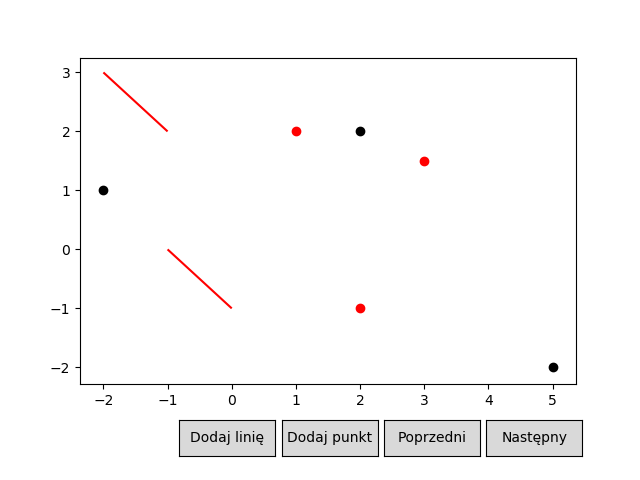

In [554]:
%matplotlib notebook
new_added_lines = []
scenes = []
scenesQQ=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]], color='red')])]

plot = Plot(scenesQQ)
plot.add_scene(Scene([PointsCollection([(2, 1)])], [LinesCollection([[(1,2),(2,3)]])]))
plot.draw() 


In [ ]:
new_added_lines

###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

In [ ]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

### Rozwiązanie

In [6]:
new_added_lines = []

<IPython.core.display.Javascript object>


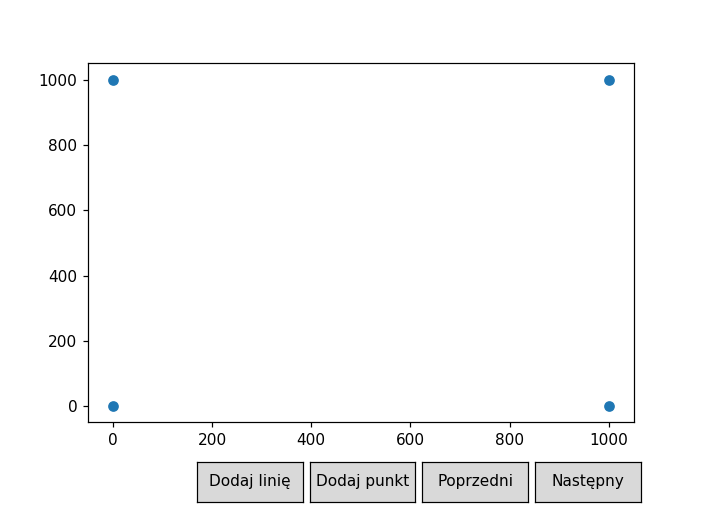

In [7]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(0,0),(0,1000),(1000,0),(1000,1000)])], [get_all_lines()])]

plot = Plot(scenes)
plot.draw() 



In [8]:
gen_lines(10)

In [641]:
new_added_lines = []

<IPython.core.display.Javascript object>


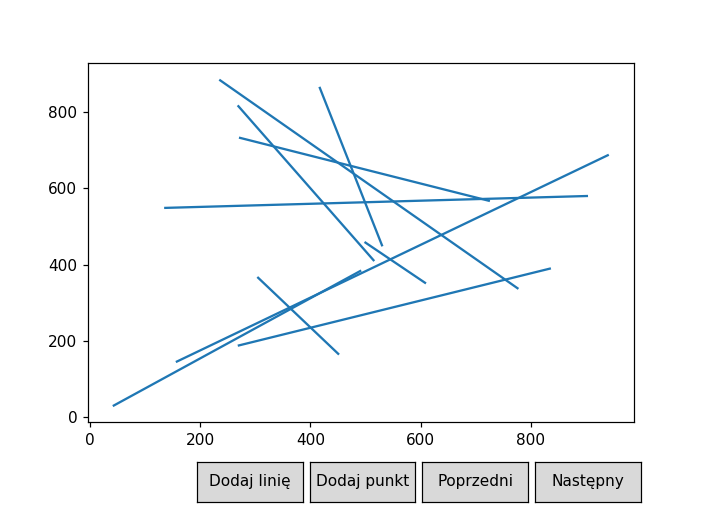

In [9]:
%matplotlib notebook

scenes=[Scene([], [get_all_lines()])]

plot = Plot(scenes)
plot.draw() 

Wersja 1 algorytmu

In [12]:
def sweep_v1():
    maxY = 100
    action_points_X = sorted([line[0][0] for line in new_added_points] + [line[1][0] for line in new_added_points])
    intersection_points_list = []
    # iteracja
    for mX in action_points_X:
        lines_list = new_added_points
        cross_lines = []
        for line in lines_list:
            if(intersect(line[0], line[1], (mX, 0), (mX, maxY)) and max(line[0][0], line[1][0]) != mX):
                cross_lines.append(line)

        def keyFun(line):
            return intersect_point(line[0], line[1], (mX, 0), (mX, maxY))
        sorted_cross_lines = sorted(cross_lines, key=keyFun)
        
        for i, line_A in enumerate(sorted_cross_lines[:-1]):
            line_B = sorted_cross_lines[i+1];
            if(intersect(line_A[0], line_A[1], line_B[0], line_B[1])):
                intersection_points_list.append(intersect_point(line_A[0], line_A[1], line_B[0], line_B[1]))
    return  intersection_points_list
    


Wersja 2 algorytmu - poprawiona

In [16]:
"start", "end", "cross"
class Event:
    def __init__(self, type, point, line=None, cross=None):
        self.type = type
        self.point = point
        self.line = line
        self.cross = cross
        
    def __repr__(self):
        return "Event {} :: {}".format(self.type, self.point)
    def __lt__(self, other): return self.point.x < other.point.x
    def __gt__(self, other): return self.point.x > other.point.x
    
def sort_events(events):
    heapq.heapify(events)
    return (events)

maxY = 1000

def intersect_with_sweeper(line, mX): 
    #return Point(line, line)
    return intersect_point(line[0], line[1], (mX, 0), (mX, maxY))

def insert_line(array, line, mX):
    if(len(array)) == 0: 
        array.append(line)
        return len(array)-1
    
    myIntersection = intersect_with_sweeper(line, mX)
    if(len(array)) == 1: 
        if(intersect_with_sweeper(array[0], mX).y < myIntersection.y):
            array.append(line)
            return len(array)-1
        else:
            array.insert(0, line)
            return 0
    
    myIntersection = intersect_with_sweeper(line, mX)
    low = 0
    high = len(array)
    mid = int((low+high)/2)
    while(high - low > 1):
        mid = int((low+high)/2)
        midIntersection = intersect_with_sweeper(array[mid], mX)
        if(midIntersection.y <= myIntersection.y):
            low = mid
        else:
            high = mid
    
    # low - element mniejszy
    # high - poza listą lub element wiekszy
    if(high < len(array)):
        if(intersect_with_sweeper(array[high], mX).y < myIntersection.y):
            array.append(line)
            return len(array) -1
        else:
            if(intersect_with_sweeper(array[low], mX).y < myIntersection.y):
                array.insert(high, line)
                return high
            else:
                array.insert(low, line)
                return low
    else:
        array.append(line) 
        return len(array) -1

def find_line(array, line, mX):
    if(len(array)) == 0: 
        return None  
    myIntersection = intersect_with_sweeper(line, mX)
    low = 0
    high = len(array)
    while(high - low > 1):
        mid = int((low+high)/2)
        midIntersection = intersect_with_sweeper(array[mid], mX)
        if(midIntersection.y <= myIntersection.y):
            low = mid
        else:
            high = mid
    
    # low - element mniejszy
    # high - poza listą lub element wiekszy
    if(high < len(array) and array[high] == line): return high
    else:
        if(high < len(array)): low = high
        while(low < len(array) and abs(myIntersection.y - intersect_with_sweeper(array[low], mX).y) < 10**(-9) ):
            low += 1
        low -= 1
        while(low >= 0 and abs(myIntersection.y - intersect_with_sweeper(array[low], mX).y) < 10**(-9) ):
            if(array[low] == line): return low
            low -= 1
    return None


def sweep():
    for line in new_added_lines:
        line.lower_node = None
        line.higher_node = None
    mX = 0
    animation_scene_list = []
    intersection_points_list = []
    
    def intersect_with_sweeper(line): return intersect_point(line[0], line[1], (mX, 0), (mX, maxY)).y
    
    def test_intersection(ind1, ind2):
        if(ind1<0 or ind1>=len(cross_lines) or ind2<0 or ind2>=len(cross_lines)): return
        line_A = cross_lines[ind1]
        line_B = cross_lines[ind2]
        intersection = line_A.intersect(line_B)
        if(intersection is not None and intersection.x > mX):
            if(intersection not in intersection_points_list):
                cross_event = Event("cross", intersection, cross=(line_A, line_B))
                heapq.heappush(event_points, cross_event)
                intersection_points_list.append(intersection)
    
    start_points = [Event("start", line[0], line) for line in new_added_lines]
    end_points =  [Event("end", line[1], line) for line in new_added_lines]
    event_points = sort_events(start_points + end_points)
    
    lines_list = new_added_lines
    cross_lines = []

    while(len(event_points) > 0):
        cEvent = heapq.heappop(event_points)
        mX = cEvent.point.x

        if(cEvent.type == "start"): 
            insert_index = insert_line(cross_lines, cEvent.line, mX)
            test_intersection(insert_index-1, insert_index)
            test_intersection(insert_index, insert_index+1)
            
            animation_scene_list.append( 
                Scene([PointsCollection([(cEvent.point.x, cEvent.point.y)], color='green'), PointsCollection([(0,0),(0,1000),(1000,0),(1000,1000)], color='w'), PointsCollection(points_as_list(intersection_points_list), color='black')],
                     [LinesCollection([line.as_list() for line in cross_lines], color='blue'), LinesCollection([cEvent.line.as_list()], color='red'),LinesCollection([[(mX,0), (mX,maxY)]], color='y'),]))
        
        elif(cEvent.type == "end") : 
            lineIndex = find_line(cross_lines, cEvent.line, mX)
            del cross_lines[lineIndex]
            test_intersection(lineIndex-1, lineIndex)
            
            animation_scene_list.append( 
                Scene([PointsCollection([(cEvent.point.x, cEvent.point.y)], color='green'),PointsCollection([(0,0),(0,1000),(1000,0),(1000,1000)], color='w'),PointsCollection(points_as_list(intersection_points_list), color='black')],
                     [LinesCollection([line.as_list() for line in cross_lines], color='blue'),LinesCollection([cEvent.line.as_list()], color='red'),LinesCollection([[(mX,0), (mX,maxY)]], color='y'),]))

        elif(cEvent.type == "cross"): 
            index1_temp = find_line(cross_lines, cEvent.cross[0], mX)
            index2_temp = find_line(cross_lines, cEvent.cross[1], mX)

            index1 = min(index1_temp, index2_temp)
            index2 = max(index1_temp, index2_temp)

            cross_lines[index1], cross_lines[index2] = cross_lines[index2], cross_lines[index1]
            test_intersection(index1-1, index1)
            test_intersection(index2, index2+1)
            
            cross_lines[index1].higher_node = cross_lines[index2]
            cross_lines[index2].lower_node = cross_lines[index1]
                        
            animation_scene_list.append( 
                Scene([PointsCollection([(cEvent.point.x, cEvent.point.y)], color='green'),PointsCollection([(0,0),(0,1000),(1000,0),(1000,1000)], color='w'),PointsCollection(points_as_list(intersection_points_list), color='black')],
                     [LinesCollection([line.as_list() for line in cross_lines], color='blue'),LinesCollection([cEvent.cross[1].as_list()], color='red'),LinesCollection([cEvent.cross[0].as_list()], color='red'),LinesCollection([[(mX,0), (mX,maxY)]], color='y'),]))
         
    return  intersection_points_list, animation_scene_list
    
#sweep()

<IPython.core.display.Javascript object>


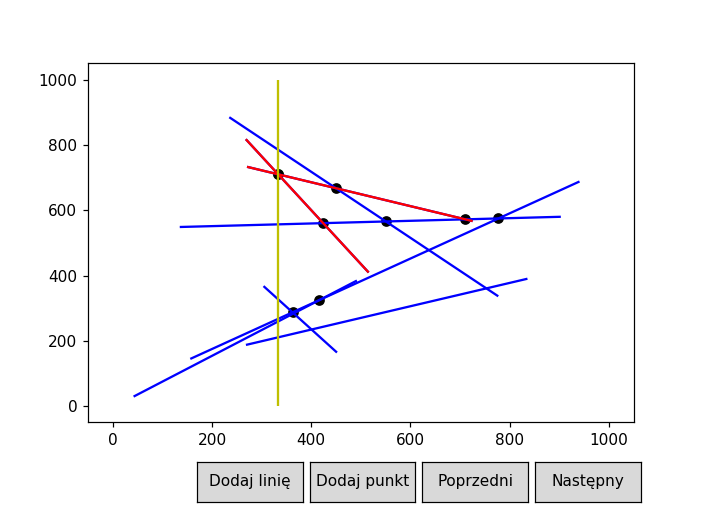

In [17]:
%matplotlib notebook
sweep_points, animation = sweep()
scenes=[Scene([PointsCollection(points_as_list(sweep_points), color="red")], [get_all_lines()])]

plot = Plot(scenes+animation)
plot.draw() 